In [1]:
import attr
import torch
import pandas as pd
import matplotlib.pyplot as plt




@attr.s(auto_attribs=True)
class Individual:
    """Represents an individual in a population."""
    haplotypes: torch.Tensor  # Shape: (ploidy, n_chromosomes, n_loci_per_chr)
    phenotype: torch.Tensor = None
    genetic_values: torch.Tensor = None
    sex: str = None
    id: int = None
    mother_id: int = None
    father_id: int = None

    @property
    def allele_dosage(self):
        """Calculates the allele dosage from the haplotypes."""
        return self.haplotypes.sum(dim=0)  # Sum across the ploidy dimension


@attr.s(auto_attribs=True)
class Population:
    """Manages a collection of individuals."""
    individuals: list[Individual] = attr.Factory(list)
    sim_param: 'SimParam' = None

    def __len__(self):
        return len(self.individuals)
    
    def generate_random_founders(self, n_founders: int):
        """Generates a founder population with random haplotypes."""
        for i in range(n_founders):
            haplotypes = torch.randint(
                0, 2, (self.sim_param.ploidy, self.sim_param.n_chromosomes, self.sim_param.n_loci_per_chr)
            )
            individual = Individual(haplotypes=haplotypes, id=i + 1)
            self.individuals.append(individual)

    def set_phenotypes(self, varE: torch.Tensor):
            """Sets phenotypes for all individuals in the population."""
            n_traits = self.sim_param.n_traits
            # assert varE.size(0) == n_traits, f"varE should have the same number of elements as traits ({n_traits})"
            for individual in self.individuals:
                genetic_value = self.calculate_genetic_value(individual)
                environmental_noise = torch.randn(n_traits) * torch.sqrt(varE)
                individual.phenotype = genetic_value + environmental_noise
                individual.genetic_values = genetic_value

    def calculate_genetic_value(self, individual: Individual):
            """Calculates the genetic value for an individual for all traits."""
            total_genetic_value = torch.zeros(self.sim_param.n_traits)
            for trait_idx, trait in enumerate(self.sim_param.traits):
                genetic_value = trait.mean
                for chr in range(self.sim_param.n_chromosomes):
                    for ploidy_idx in range(self.sim_param.ploidy):
                        for qtl_idx in range(trait.n_qtl_per_chr):
                            qtl_location = trait.qtl_locations[chr, ploidy_idx, qtl_idx]
                            allele_dosage = individual.allele_dosage[chr, qtl_location]
                            effect = trait.qtl_effects[chr, ploidy_idx, qtl_idx]
                            genetic_value += allele_dosage * effect
                total_genetic_value[trait_idx] = genetic_value # Assign the genetic value for each trait to the correct index
            return total_genetic_value



@attr.s(auto_attribs=True)
class Trait:
    """Defines parameters for a trait."""
    mean: float
    variance: float
    n_qtl_per_chr: int 
    qtl_effects: torch.Tensor = None
    qtl_locations: torch.Tensor = None

    def generate_qtl_effects(self, n_chromosomes, ploidy,  n_loci_per_chr):
        """Generates QTL effects and their locations."""
        qtl_effects = torch.randn(n_chromosomes, ploidy, self.n_qtl_per_chr) * torch.sqrt(torch.tensor(self.variance))
        
        qtl_locations = []
        for _ in range(n_chromosomes):
            for _ in range(ploidy):
                qtl_locations.append(torch.randperm(n_loci_per_chr)[:self.n_qtl_per_chr])
                
        qtl_locations = torch.stack(qtl_locations).view(n_chromosomes, ploidy, self.n_qtl_per_chr)
        # Assert that qtl_effects and qtl_locations have the same shape

        assert qtl_effects.shape == qtl_locations.shape, "Shapes of qtl_effects and qtl_locations do not match"
        self.qtl_effects = qtl_effects
        self.qtl_locations = qtl_locations

@attr.s(auto_attribs=True)
class SimParam:
    """Stores global simulation parameters."""
    n_chromosomes: int = 10
    ploidy: int = 2
    traits: list[Trait] = attr.Factory(list)
    n_loci_per_chr: int = 100
    n_traits: int = None
    corA: torch.Tensor = None # Correlation matrix
    
    def __str__(self):
        """Returns a string representation of the simulation parameters."""
        trait_info = "\n".join(
            f"  Trait {i+1}: mean={trait.mean}, variance={trait.variance}, n_qtl={trait.n_qtl_per_chr}" 
            for i, trait in enumerate(self.traits)
        )

        return (
            f"Simulation Parameters:\n"
            f"  Number of Chromosomes: {self.n_chromosomes}\n"
            f"  Ploidy: {self.ploidy}\n"
            f"  Loci per Chromosome: {self.n_loci_per_chr}\n"
            f"  Number of Traits: {self.n_traits}\n"
            f"  Additive Genetic Correlation (corA):\n{self.corA}\n"
            f"Traits:\n{trait_info}\n"
        )
    # ... (Other simulation parameters)

    def add_trait_A(self, means: torch.Tensor, variances: torch.Tensor, corA: torch.Tensor, n_qtl_per_chr: int):
        """
        Creates multiple additive traits and adds them to the simulation.

        Parameters:
        - means: Tensor of mean values for the traits
        - variances: Tensor of variance values for the traits
        - corA: The correlation matrix between additive effects.
        
        Assumption:
        - n_qtl_per_chr: equal number of qtl per chromosome
        """
        self.n_traits = means.size(0) # Set the number of traits
        self.corA = corA # Store the correlation matrix

        assert means.size(0) == variances.size(0) == corA.size(0) == corA.size(1), \
               "means, variances, corA must have compatible dimensions."
        
        # Cholesky decomposition to generate correlated effects
        L = torch.linalg.cholesky(corA)

        # Generate QTL effects for all traits
        qtl_effects = torch.randn(self.n_traits, self.n_chromosomes, self.ploidy, n_qtl_per_chr)
        
        # Apply Cholesky transformation for correlation
        correlated_effects = L @ qtl_effects.view(self.n_traits, -1) # Matrix multiplication
        correlated_effects = correlated_effects.view(self.n_traits, self.n_chromosomes, self.ploidy, n_qtl_per_chr)

        # Scale for desired variance
        for i in range(self.n_traits):
            correlated_effects[i] *= torch.sqrt(variances[i]) # Scale by the square root of the variance

        qtl_locations = []
        for _ in range(self.n_chromosomes):
            for _ in range(self.ploidy):
                qtl_locations.append(torch.randperm(self.n_loci_per_chr)[:n_qtl_per_chr])
                
        qtl_locations = torch.stack(qtl_locations).view(self.n_chromosomes, self.ploidy, n_qtl_per_chr)

        # Create Trait objects and add them to the simulation
        for i in range(self.n_traits):
            trait = Trait(mean=means[i].item(), variance=variances[i].item(), n_qtl_per_chr=n_qtl_per_chr)
            trait.qtl_effects = correlated_effects[i]
            trait.qtl_locations = qtl_locations
            self.traits.append(trait)

def get_all_phenotypes(population: Population) -> torch.Tensor:
    """Returns a tensor of all phenotypes in the population.

    Args:
        population (Population): The population object.

    Returns:
        torch.Tensor: A tensor of shape (n_individuals, n_traits) containing all phenotypes.
    """
    assert population.individuals[0].phenotype != None, "You havent phenotyped yet. Use `population.set_phenotype(varE)`"
    return torch.stack([individual.phenotype for individual in population.individuals])

def get_all_genetic_values(population: Population) -> torch.Tensor:
    """Returns a tensor of all genetic values in the population.

    Args:
        population (Population): The population object.

    Returns:
        torch.Tensor: A tensor of shape (n_individuals, n_traits) containing all genetic values.
    """
    return torch.stack([individual.genetic_values for individual in population.individuals])

# Simulation parameters
sim_param = SimParam(n_chromosomes=2, n_loci_per_chr=50, ploidy=2) # Create a population
# Population setup
population = Population(sim_param=sim_param)
population.generate_random_founders(n_founders=100)

# Define correlated additive traits
# Define the correlation matrix
corA = torch.tensor([[1.0, -0.9], [-0.9, 1.0]]) 
# Add traits with correlation
sim_param.add_trait_A(means=torch.tensor([1.25, 1.5]), variances=torch.tensor([2.0, 0.5]), corA=corA, n_qtl_per_chr=10)

# Phenotype the population(once)
population.set_phenotypes(varE=torch.tensor(1.0))

print(sim_param)



Simulation Parameters:
  Number of Chromosomes: 2
  Ploidy: 2
  Loci per Chromosome: 50
  Number of Traits: 2
  Additive Genetic Correlation (corA):
tensor([[ 1.0000, -0.9000],
        [-0.9000,  1.0000]])
Traits:
  Trait 1: mean=1.25, variance=2.0, n_qtl=10
  Trait 2: mean=1.5, variance=0.5, n_qtl=10



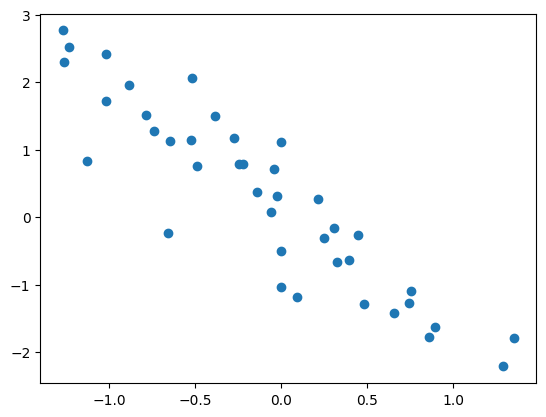

In [2]:
plt.scatter(sim_param.traits[1].qtl_effects.flatten().numpy(), sim_param.traits[0].qtl_effects.flatten().numpy())

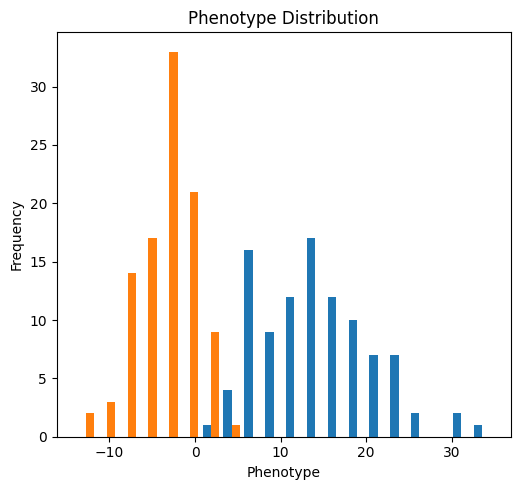

In [3]:

# Set phenotype
# population = set_phenotype(population, varE=1.0)
# Get all phenotypes and genetic values
phenotypes = get_all_phenotypes(population)
genetic_values = get_all_genetic_values(population)

# --- Plotting ---
plt.figure(figsize=(10, 5))

# Histogram of phenotypes
plt.subplot(1, 2, 1)
plt.hist(phenotypes.numpy(), bins=20)
plt.title("Phenotype Distribution")
plt.xlabel("Phenotype")
plt.ylabel("Frequency")

# # Scatter plot of genetic values vs phenotypes
# plt.subplot(1, 2, 2)
# plt.scatter(genetic_values.numpy(), phenotypes.numpy())
# plt.title("Genetic Value vs Phenotype")
# plt.xlabel("Genetic Value")
# plt.ylabel("Phenotype")

plt.tight_layout()
plt.show()

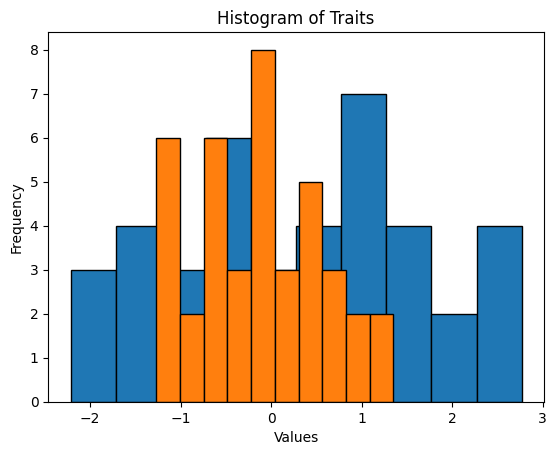

In [4]:
# Create a histogram
plt.hist(sim_param.traits[0].qtl_effects.flatten().numpy(), bins=10, edgecolor='black')
plt.hist(sim_param.traits[1].qtl_effects.flatten().numpy(), bins=10, edgecolor='black')

# Add titles and labels
plt.title('Histogram of Traits')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Show the plot
plt.show()
